# **Exam Project for the course *Applied Machine Learning (Basic)***

Instructor: Prof. D. Bonacorsi

TA: Dott. L. Giommi, Dott. T. Diotalevi

A.A. 2019-2020

Student: Marcello Zanghieri (DS&C)

---

## Project topic:
## Surface electromyography (sEMG)-based hand gesture recognition with ML

**Dataset.** The public dataset Non-Invasive Adaptive Prostethics Database 2 (NinaProDB2):
*   website: http://ninaweb.hevs.ch
*   paper: https://www.researchgate.net/publication/261840086_Movement_Error_Rate_for_Evaluation_of_Machine_Learning_Methods_for_sEMG-Based_Hand_Movement_Classification

For computation size reasons, this project is limited to the DB's Subject 1 (out of 40), and to the Exercise 1 (out of 3), which contains 17 discrete gestures plus the rest class $0$, totalling $G = 18$ classes. Each movements is performed for 6 repetitions, during $\sim 3 \text{s}$, interleaved by $\sim 5 \text{s}$ of rest position (class $0$).

**Data format.** Each datum to classify is a $12$-feature sample. Each feature is the sEMG value from one electrode, computed as Root Mean Square (RMS) on a $400\text{ms}$ window of the raw signal. In this project, data are subsampled $200\times$, from $2\text{kHz}$ to $10\text{Hz}$, after RMS envelope extraction, again to grant computational slenderness.

**Algorithms.** Radial Basis Function-kernel Support Vector Machines (RBF-SVM), with the kernel's $\gamma_\text{RBF} = \texttt{gamma = 'scale'}$ kept fixed, applied to the data pre-standardized channel-wise.

**Target metric.** The dataset has a very strong imbalance:
*   the rest class $0$ accounts for $58.9\%$
*   across the $17$ movement classes, the the least represented is gesture $15$, with $1.3\%$, and the most represented is gesture $1$, with $4.3\%$: a further $3.3\times$ ratio between minorities!

**Procedure.**
*   $60\%$-$20\%$-$20\%$ train-val-test split
*   hyperparameter tuning on $C_\text{SVM}$, explored in logarithmic scale 
*   model comparison, model selection, and test

In [1]:
# General imports

import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

# Scikit-Learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

*A note for **reproducibility**.*

*Scikit-Learn uses NumPy's random generator:*
*   https://scikit-learn.org/stable/faq.html#how-do-i-set-a-random-state-for-an-entire-execution
*   https://www.mikulskibartosz.name/how-to-set-the-global-random_state-in-scikit-learn/

*In this project, randomness comes into play only when shuffling prior to dataset split, which is made reproducible by setting* ```train_test_split```*'s* ```random_state``` *parameter, whereas* ```sklearn.svm.SVC.fit``` *is deterministic.*

*However, I set the seed in general, to arrange for possible future changes in the project's flow.*

In [2]:
np.random.seed(0)

## **Data**
Get the data:
*   $\mathbf{X}$ sEMG data: shape ```(M, C)``` and type ```np.float32```
*   $\mathbf{Y}$ groud truth labels: shape ```(M,)``` and type ```np.int```

where $M = 9038$ is the number of samples @$10\text{Hz}$ (i.e., $\approx 15\text{min}$ exercise duration) and $C = 12$ is the number of features, i.e. sEMG electrodes.

In [3]:
# clean gColab runtime's working directory from default files
!rm -r /content/*
# download data file from my GitHub
!wget https://raw.githubusercontent.com/MarcelloZanghieri2/project_AML/master/NinaProDB2_s1_e1_RMS400ms_sub10Hz.pkl

data = pickle.load(open('NinaProDB2_s1_e1_RMS400ms_sub10Hz.pkl', 'rb')) # unpickle
X = data['X'] # data matrix: (time_samples, 12sensors), float32
Y = data['Y'] # ground truth labels: (time_samples,), int
G = len(np.unique(Y)) # number of classes, got programmatically; G stands for "gesture"

--2020-08-16 21:45:30--  https://raw.githubusercontent.com/MarcelloZanghieri2/project_AML/master/NinaProDB2_s1_e1_RMS400ms_sub10Hz.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452215 (442K) [application/octet-stream]
Saving to: ‘NinaProDB2_s1_e1_RMS400ms_sub10Hz.pkl’

NinaProDB2_s1_e1_RM 100%[===================>] 441.62K  --.-KB/s    in 0.06s   

2020-08-16 21:45:30 (7.00 MB/s) - ‘NinaProDB2_s1_e1_RMS400ms_sub10Hz.pkl’ saved [452215/452215]



Visualizations to show the nature of the data, and qualitatively see some classes' patterns: classes $0$, $2$, $6$, $15$ and $16$ taken as examples.

**NB.** The sEMG signals are in arbitrary units (a.u.), but the ratios are always preserved across channels and across gestures.

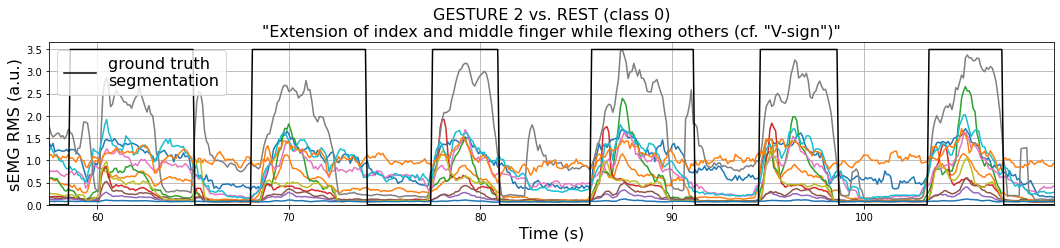

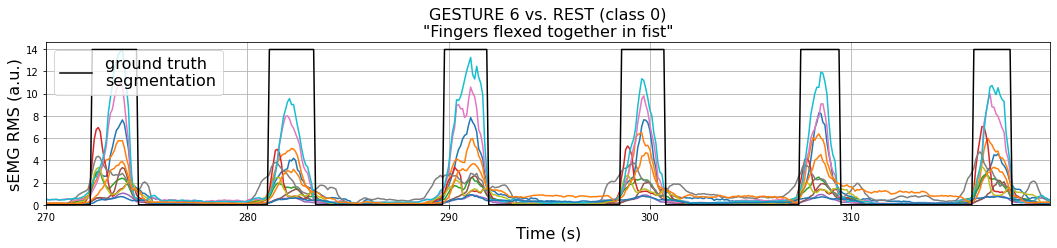

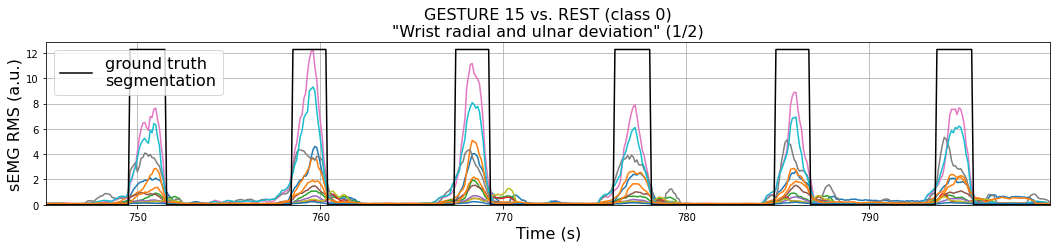

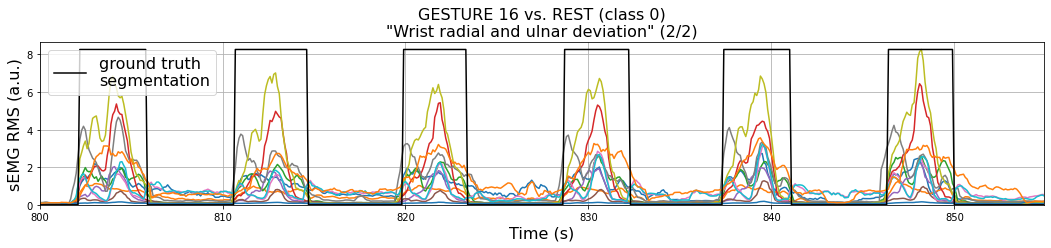

In [4]:
stdX = X.std() # rescaling factor for visualization

v_Hz = 10.0 # frequency (in Hz), to convert sample indices into time values

gesture_description = { # class description, from paper [Gisberts 2014]
     2: '"Extension of index and middle finger while flexing others (cf. "V-sign")"',
     6: '"Fingers flexed together in fist"',
    15: '"Wrist radial and ulnar deviation" (1/2)',
    16: '"Wrist radial and ulnar deviation" (2/2)',
}

gesture_span_samples = { # approximate boundaries
     2: ( 575, 1100),
     6: (2700, 3200),
    15: (7450, 8000), 
    16: (8000, 8550),
    }

for k in gesture_span_samples:
    print('\n')
    
    S0, S1 = gesture_span_samples[k]  # estremes
    time_s = np.arange(S0, S1) / v_Hz # time values
    x = X[S0:S1] / stdX               # rescaling
    y = (Y[S0:S1] != 0) * x.max()     # y = 0 for rest, y = 1 for class

    plt.figure(figsize=(18, 3))
    plt.plot(time_s, x)
    plt.plot(time_s, y, 'k-', label='ground truth\nsegmentation')
    plt.axis([time_s.min(), time_s.max(), 0, None])
    plt.grid()
    plt.title('GESTURE %d vs. REST (class 0)\n%s' % (k, gesture_description[k]), fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel('sEMG RMS (a.u.)', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.show()

**NB.** The sEMG signals are in arbitrary units (a.u.), but the ratios are always preserved across channels and across gestures.

It is apparent that:
*   rest class $0$ is characterized by low activity for all the channels;
*   different gestures have different patterns.

## **Dataset split**
Three-way data split, with validation set and test set made simply by **holdout**: no $K$-fold, to keep training computation low.

Proportions:
*   $60\%$ training set
*   $20\%$ validation set
*   $20\%$ training set

In [5]:
test_fraction  = 0.2
val_fraction   = 0.2
train_fraction = 1 - val_fraction - test_fraction

XTrainVal, XTest, YTrainVal, YTest = train_test_split(
    X, Y, stratify=Y,
    test_size=test_fraction,
    shuffle=True, random_state=0,
    )

XTrain, XVal, YTrain, YVal = train_test_split(
    XTrainVal, YTrainVal, stratify=YTrainVal,
    test_size=val_fraction / (1 - test_fraction), # readjusted as needed
    shuffle=True, random_state=0,
    )

M      = len(Y)      # dataset size
MTrain = len(YTrain) # training set size
MVal   = len(YVal)   # validation set size
MTest  = len(YTest)  # test set size

# print some information
print('(SUB-)DATASET SIZES')
print('Total elements:      M      = %d values of 400ms-RMS, from subsampling @10Hz after envelope.' % M)
print('Training elements:   MTrain = %d (%.0f%%)' % (MTrain, 100 * train_fraction))
print('Validation elements: MVal   = %d (%.0f%%)' % (MVal  , 100 * val_fraction  ))
print('Test elements:       MTest  = %d (%.0f%%)' % (MTest , 100 * test_fraction ))

(SUB-)DATASET SIZES
Total elements:      M      = 9038 values of 400ms-RMS, from subsampling @10Hz after envelope.
Training elements:   MTrain = 5422 (60%)
Validation elements: MVal   = 1808 (20%)
Test elements:       MTest  = 1808 (20%)


Class-inbalance check (on the training set only).

Notation:
*   $g = 1, \cdots, G - 1$, with $G = 18$: class index, stands for *gesture*;
*   $m_g^\text{(train)} = \dfrac{M_g^\text{(train)}}{M^\text{(train)}}$: proportion of class $g$

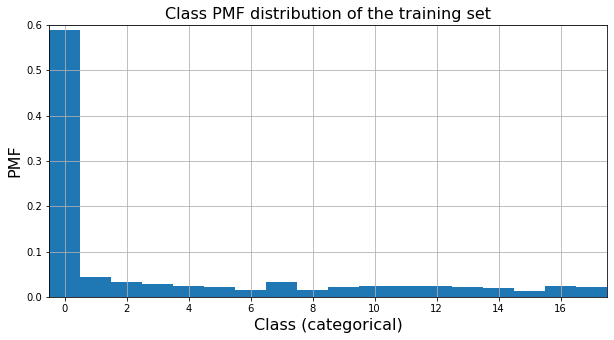


CLASS-IMBALANCE (training data only)
Portion of rest, class 0: 58.9%
Least represented gesture: class 15, with 1.3%
Most represented gesture: class 1, with 4.3%
Ratio between class 15 and 1 representations: 3.31


In [6]:
# PMF histogram of classes in the training set
plt.figure(figsize=(10, 5))
plt.title('Class PMF distribution of the training set', fontsize=16)
plt.xlabel('Class (categorical)', fontsize=16)
plt.ylabel('PMF', fontsize=16)
plt.hist(YTrain, range=(-0.5, -1 + G + 0.5), bins=G, density=True)
plt.grid()
plt.axis([-0.5, -1 + G + 0.5, 0, 0.6])
#plt.xticks(np.arange(G))
plt.show()


m_g = np.array([(YTrain == g).mean() for g in range(G)])

g_min = m_g.argmin()
m_min = m_g[g_min]

g_max = m_g[1:].argmax() + 1 # exclude class 0
m_max = m_g[g_max]

mmax_to_mmin_ratio = m_max / m_min

# print the results
print('\nCLASS-IMBALANCE (training data only)')
print('Portion of rest, class 0: %.1f%%' % (100 * m_g[0]))
print('Least represented gesture: class %d, with %.1f%%' % (g_min, 100 * m_min))
print('Most represented gesture: class %d, with %.1f%%' % (g_max, 100 * m_max))
print('Ratio between class %d and %d representations: %.2f' % (g_min, g_max, mmax_to_mmin_ratio))

...as reported in the introduction. This is what motivates the use of the ***balanced* accuracy** $A_\text{b}$, defined as the average *recall* (or *sensitivity*: accuracy on a 1-class set) over all classes, thus weighting each the same regardless of its representation; this is equivalent to weighting each sample inversely proportionally to its class' proportion in the evaluation set.

Balanced accuracy is implemented by Scikit-Learn scoring function ```sklearn.metrics.balanced_accuracy_score```.

## **Model and hyperparameter optimization**

The model explored in this project is the RBF-SVM, implemented by the ```sklearn.svm.SVC``` class with ```kernel='rbf'```. The data are standardized channel-wise using the training set statistics via ```sklearn.preprocessing.StandardScaler```, which for clarity I re-instantiate before each SVM, creating 12 ```sklearn.pipeline.Pipeline```s.

The search for the optimal $C_\text{SVM}$ is done sweeping the regimes in logarithmic scale:

$\log_{10} C = -4, -3, \cdots, +6, +7$,

totalling $N_C = 12$ models.

The extremes are clearly extreme (indeed), but in addition to finding $C_\text{opt}^\text{(val)}$ I want to see the whole landscape.



### **Balanced training**
Just like I choose to rebalance the classes in the scoring by using the balanced accuracy, I make the training balanced to by setting ```class_weight='balanced'``` when instantiating the ```SVC```. This adjusts the $C$ to $C / m_g^\text{(train)}$ class-wise, to weight the training classification errors inversely proportionally to the proportion of classes.

In [7]:
# C values
Log10_Cmin = -4  # lower extreme of C, in log10 scale
Log10_Cmax =  7 # upper extreme of C, in log10 scale
NC = Log10_Cmax - Log10_Cmin + 1 # total number of competing C's
C = 10**np.arange(Log10_Cmin, 1 + Log10_Cmax, dtype=np.float) # values of C


# results to store for each models
pipeline    = [None for nc in range(NC)] # collection of all the stdz+SVM pipelines
timeTrain_s = np.zeros(NC)               # training computation time (in s)
timeInfer_s = np.zeros(NC)               # validation computation time (in s)
nSV         = np.zeros(NC)               # number of support vectors
YTrainHat   = np.zeros((NC, MTrain))     # training assignments by all models
aTrain      = np.zeros(NC)               # training balanced accuracies
YValHat     = np.zeros((NC, MVal  ))     # training assignments by all models
aVal        = np.zeros(NC)               # validation balanced accuracies


# trainings and validations
print('\nTRAININGS AND VALIDATIONS\nExpected computation time < 5mins\n')
for nc in range(NC):
    print('\nTraining model %d/%d:\nC = %.0e' % (1 + nc, NC, C[nc]))
    
    scaler = StandardScaler() # channel-wise standardization stage

    svc = SVC(                # Support Vector Classifier
        decision_function_shape='ovo',
        gamma = 'scale',
        kernel='rbf',
        C=C[nc],                 # each model's C
        class_weight='balanced', # balanced training
    )
    
    pipeline[nc] = Pipeline([('standardization', scaler), ('svc', svc)], verbose=True)

    # training
    t0_s = time.time()
    pipeline[nc].fit(XTrain, YTrain)
    timeTrain_s[nc] = time.time() - t0_s

    nSV[nc] = pipeline[nc].steps[1][1].n_support_.sum()
    
    # inference on training set and validation set
    t0_s = time.time()
    YTrainHat[nc] = pipeline[nc].predict(XTrain)
    YValHat[nc]   = pipeline[nc].predict(XVal  )
    timeInfer_s[nc] = time.time() - t0_s
    
    aTrain[nc] = balanced_accuracy_score(YTrain, YTrainHat[nc])
    aVal[nc]   = balanced_accuracy_score(YVal  , YValHat[nc]  )
    print('Training balanced accuracy:   %.3f' % aTrain[nc])
    print('Validation balanced accuracy: %.3f' % aVal[nc]  )


TRAININGS AND VALIDATIONS
Expected computation time < 5mins


Training model 1/12:
C = 1e-04
[Pipeline] ... (step 1 of 2) Processing standardization, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=  10.6s
Training balanced accuracy:   0.056
Validation balanced accuracy: 0.056

Training model 2/12:
C = 1e-03
[Pipeline] ... (step 1 of 2) Processing standardization, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=  10.6s
Training balanced accuracy:   0.056
Validation balanced accuracy: 0.056

Training model 3/12:
C = 1e-02
[Pipeline] ... (step 1 of 2) Processing standardization, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   8.3s
Training balanced accuracy:   0.513
Validation balanced accuracy: 0.476

Training model 4/12:
C = 1e-01
[Pipeline] ... (step 1 of 2) Processing standardization, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   2.7s
Training balanced accuracy

Visualizing of some curves provides useful insight.

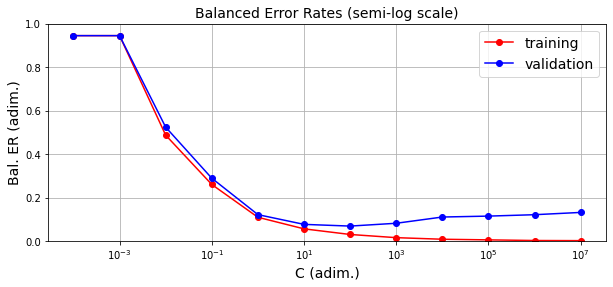

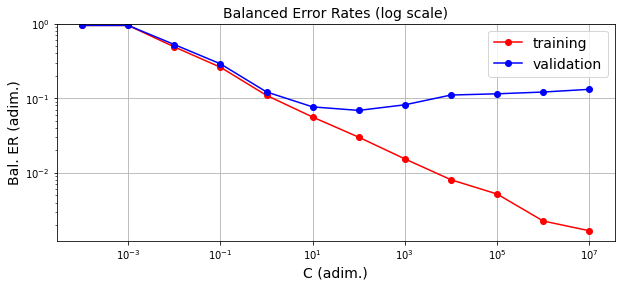

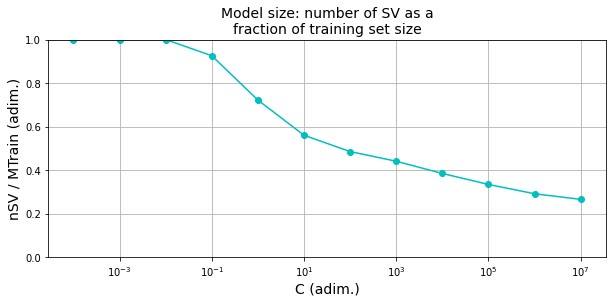

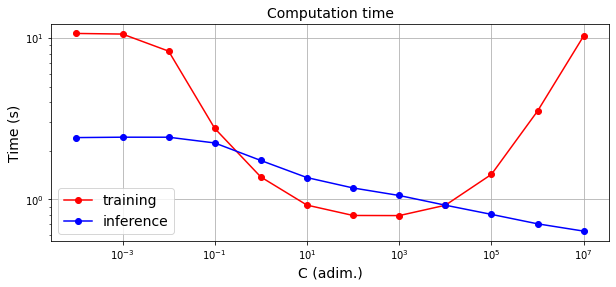

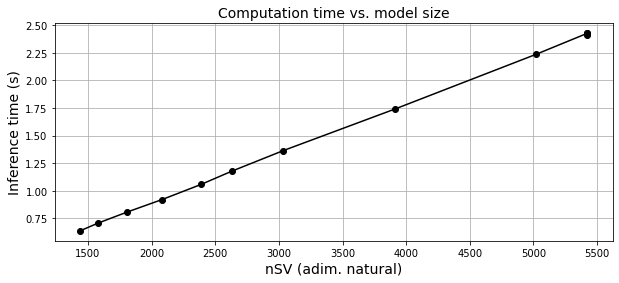

In [8]:
# balanced error rate, in semi-log scale
plt.figure(figsize=(10, 4))
plt.title('Balanced Error Rates (semi-log scale)', fontsize=14)
plt.xlabel('C (adim.)', fontsize=14)
plt.ylabel('Bal. ER (adim.)', fontsize=14)
plt.plot(C, 1 - aTrain, 'ro-', label='training')
plt.plot(C, 1 - aVal, 'bo-', label='validation')
plt.legend(fontsize=14)
plt.xscale('log')
plt.grid()
plt.axis([None, None, 0, 1])
plt.show()
print('\n')

# balanced error rate, in log-log scale
plt.figure(figsize=(10, 4))
plt.title('Balanced Error Rates (log scale)', fontsize=14)
plt.xlabel('C (adim.)', fontsize=14)
plt.ylabel('Bal. ER (adim.)', fontsize=14)
plt.plot(C, 1 - aTrain, 'ro-', label='training')
plt.plot(C, 1 - aVal, 'bo-', label='validation')
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.axis([None, None, None, 1])
plt.show()
print('\n')


# model size
plt.figure(figsize=(10, 4))
plt.title('Model size: number of SV as a\nfraction of training set size', fontsize=14)
plt.xlabel('C (adim.)', fontsize=14)
plt.ylabel('nSV / MTrain (adim.)', fontsize=14)
plt.plot(C, nSV / MTrain, 'co-')
plt.xscale('log')
plt.grid()
plt.axis([None, None, 0, 1])
plt.show()
print('\n')


# computation time
plt.figure(figsize=(10, 4))
plt.title('Computation time', fontsize=14)
plt.xlabel('C (adim.)', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.plot(C, timeTrain_s, 'ro-', label='training')
plt.plot(C, timeInfer_s, 'bo-', label='inference')
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()
print('\n')

# computation time vs. model size
plt.figure(figsize=(10, 4))
plt.title('Computation time vs. model size', fontsize=14)
plt.xlabel('nSV (adim. natural)', fontsize=14)
plt.ylabel('Inference time (s)', fontsize=14)
plt.plot(nSV, timeInfer_s, 'ko-')
plt.grid()
plt.show()

Comments on the validation results:
*   the training and validation curves have the expected trend, and the plateaus at the beginning and at the and show that the $C$ interval tried is sufficient to probe all the regimes;
*   the best value is $C = 100$, which yields $A_\text{b}^\text{(val)} = 93.1\%$;
*   however, its neighbors are very close;
*   computation time has a neat linear trend wrt to the model size, as expected.

## **Model comparison and selection**

As seen from the validation curves, the best model is the ```SVC(C=100)```. However, its neighbors are very close, and I am interested in quantifying whether the differences $n^\text{th}$-vs-$1^\text{st}$ are statistically significant.

I do so with the following heuristic:
*   each model's accuracy is treated as a sample $\{x_g\}_{g = 0, \cdots, G - 1}$ by looking at the $G = 18$ accuracies on each class separately (a procedure that again weights all classes the same);
*   comparison is made via the **Wilcoxon signed-rank statistical test**, the choiche of which is motivated by the fact that it is (*i*) paired, and (*ii*) non-parametric, thus assuming no distribution shape.

Since a precise signficance level $\alpha$ (either single- or multiple-hypothesis) is not pre-set, this procedure is not used as a real statistical test, but rather as a reasonable quantitative heuristic to decide how many top classifiers are equivalent.

In [9]:
podium = aVal.argsort()[::-1] # ranking

from scipy.stats import wilcoxon
Wstat = np.zeros(NC) # Wilcoxon statistic
Wstat[podium[0]]     # best vs itself
pW    = np.zeros(NC) # p-value of Wilcoxon test
pW[podium[0]] = 1    # best vs itself

accuracy_by_model_by_class = np.array( # accuracy of each model, on each class
    [
        [(YValHat[nc][YVal == g] == g).mean() for g in range(G)] for nc in range(NC)
    ]
)

x = accuracy_by_model_by_class[podium[0]] # first sample is always the best model's
for p in podium[1:]:
    y = accuracy_by_model_by_class[p] # second sample
    Wstat[p], pW[p] = wilcoxon(
        x, y,
        zero_method='zsplit',
        correction =False,
        alternative='greater',
        #mode      ='auto', # mode only available in SciPy >= 1.5.0
    )


print('\nRank\tC\taVal\tnSV\tpW')
rank = 0
for nc in podium:
    rank += 1
    print('%d\t%.0e\t%.3f\t%d\t%.1e' % (rank, C[nc], aVal[nc], nSV[nc], pW[nc]))


Rank	C	aVal	nSV	pW
1	1e+02	0.931	2629	1.0e+00
2	1e+01	0.924	3036	6.9e-02
3	1e+03	0.918	2388	8.8e-02
4	1e+04	0.890	2083	2.1e-03
5	1e+05	0.886	1809	5.4e-03
6	1e+06	0.879	1577	1.9e-03
7	1e+00	0.879	3913	2.1e-04
8	1e+07	0.869	1437	9.9e-04
9	1e-01	0.711	5019	1.5e-04
10	1e-02	0.476	5422	1.4e-04
11	1e-03	0.056	5422	1.2e-04
12	1e-04	0.056	5422	1.1e-04


Here is the ranking table. Clearly, the statistical test is interesting only for the top-ranking models.

With $p_\text{Wilcoxon} = 0.088$, the ```SVC(C=1000)``` (ranking $3^\text{rd}$) stands out as statistically equivalent to the best one even with the most relaxed $\alpha$ one could reasonably set.

This means that its $-1.3\%$ difference accuracy wrt the best one is not statistically significant.

A fortiori, the same holds for ```SVC(C=10)``` ranking $2^\text{nd}$. However, the $3^\text{rd}$ model is much more efficient, since it is $9.2\%$ smaller (thus faster) than the best one, whereas the $2^\text{nd}$ model is $15\%$ larger (thus slower).

**I therefore select ```SVC(C=1000)```**, which has validation accuracy $A_\text{b}^\text{(val)} = 91.8\%$ and $n_\text{SV} = 2388$ support vectors.

In [10]:
placement_selected = 2 # 3rd position
pipeline_selected = pipeline[podium[placement_selected]]

## **Test**
Assess the balanced accuracy of ```SVC(C=100)``` on $(\mathbf{X}^\text{(test)}, \mathbf{Y}^\text{(test)})$.

In [12]:
YTestHat = pipeline_selected.predict(XTest)      # test inference
aTest = balanced_accuracy_score(YTest, YTestHat) # test accuracy
drop = aTest - aVal[podium[placement_selected]]  # validation-to-test accuracy drop

print('Test accuracy: %.3f' % aTest)
print('Val-to-test drop: %.3f' % drop)

Test accuracy: 0.913
Val-to-test drop: -0.005


So, the final test balanced accuracy to claim is $A_\text{b}^\text{(test)} = 91.3\%$, which is $-2.3\%$ accuracy wrt validation.

Finally, it is possible to inspect the test confusion matrix and the test classification report.

In [13]:
MconfTest = confusion_matrix(YTest, YTestHat)
reportTest = classification_report(YTest, YTestHat)

print('\nTEST CONFUSION MATRIX\n\n', MconfTest, '\n')
print('\nTEST CLASSIFICATION REPORT\n\n', reportTest)


TEST CONFUSION MATRIX

 [[919  41  15  11   1   6   0  52   1   6   5   1   0   0   2   0   0   6]
 [  3  76   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   3  55   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   2  47   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  45   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  38   0   1   1   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  24   0   0   0   1   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0  50   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0  25   0   1   0   0   0   1   0   0   0]
 [  1   0   0   0   0   0   0   0   0  38   1   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   2  39   1   0   1   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0  36   3   1   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   3  39   0   0   0   1   0]
